In [84]:
from __future__ import division
from collections import Counter
import csv
import numpy as np
from numpy import arange
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

In [2]:
%matplotlib inline

In [3]:
%load_ext watermark

In [4]:
%watermark -a "Ranbir Dixit" -d -v -m -p numpy,scipy,pandas,matplotlib,seaborn,scikit-learn

Ranbir Dixit 2016-08-08 

CPython 2.7.11
IPython 4.2.0

numpy 1.11.0
scipy 0.17.1
pandas 0.18.1
matplotlib 1.5.1
seaborn 0.7.0
scikit-learn 0.17.1

compiler   : MSC v.1500 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [5]:
df=pd.read_csv(r'C:\Users\ranbir\OneDrive - University of Stirling\IceRobotics\Data\01_08\hourly interval_28_07_2hrs.csv')

# Step1: Answering the Question
The objective is to predict whether a prepartum dairy cow is in the calving stage at different time blocks prior to calving. The time blocks to be tested are -2hrs, -4hrs and -8hrs. As such this problem can be considered as a time-series classification problem.

## Metric's for success:
The main metric for success is the accuracy of the model. A prediction of 80% based on scientific research in the field as well as a previous study by an IceRobotics placement set this as the marker. Additional measures are sensitivity, specificity, positive predictive value and negative predictive value.Specificity of 99% and sensitivity of 80% was defined as the acceptable minimum (ISO, 2007; Borchers, 2015). Minimizing missed calving events (False Negatives) was considered to be more important than minimizing wrongly identified calving events (False Positives) and as such sensitivity accuracy was key.
## Experimental Design
Calving data was obtained from Harper Adam's University, this data consisted of Cow IDs with their associated calving dates and times. This information was then aggregated with sensor data obtained from the database. The data was cleaned and transformed and in its cleaned state consists of 3 days of data sampled at 15 minutes with 34 cows. 31 of these cows have 3 sensors attacched (BL, BR, FL), 2 have 2 sensors attached(BL and BR) and 1 has one sensor attached (FL), for a total of 98 sensors.
## Model generalizability
Even though the data was obtained from one farm, it is assumed that farm management practices are similar in majority of the farms that the company has business with and as such the behaviour of dairy cattle on this farm should generalize well to other farms of a similar design. In addition the data included cows of different parities and locomotion scores, which helps to generalize the findings further.
## Intergation into production environment
Once the models have been built, they will need to be serialized using something similar to python's pickle data format. This way the model can be intergrated into the production environment without having to retrain it each time. Data to be classified will be pulled from an SQL database that contains sensor values, these will then need to be checked for missing data. If the data is missing it will need to be imputed. In addition two new metrics will need to be calculated from the sensor data i.e. lying bouts/hr and the $$activity index=\frac{steps/hr}{standing time/hr}lying bouts/hr^2$$ 

In [6]:
#check dataframe
df.head()

,subject,start,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index,calving
0,112BL,16/08/2015 00:00,0,0,881,2719,0,0,0,NC
1,112BL,16/08/2015 01:00,54,13,1175,2425,2,1,40,NC
2,112BL,16/08/2015 02:00,33,9,428,3172,2,1,76,NC
3,112BL,16/08/2015 03:00,19,4,341,3259,2,1,42,NC
4,112BL,16/08/2015 04:00,7,1,739,2861,1,0,0,NC


In [7]:
#create a cow id column to use for splitting the data into test and train sets
df['cow_id']=df.subject.str.slice(stop=-2)

In [8]:
df.describe()

,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index
count,7056.000000,7056.000000,7056.000000,7056.000000,7056.000000,7056.000000,7056.000000
mean,146.892290,39.193594,1793.034439,1794.465561,1.272817,0.634354,108.938492
std,223.630571,64.710003,1330.526078,1328.462138,1.427374,0.788168,698.725473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,4.000000,474.000000,431.750000,0.000000,0.000000,0.000000
50%,91.000000,22.000000,1753.500000,1829.000000,1.000000,1.000000,0.000000
75%,184.000000,50.000000,3152.250000,3097.000000,2.000000,1.000000,56.000000
max,3457.000000,1054.000000,3600.000000,3600.000000,17.000000,9.000000,22500.000000


In [9]:
#check for the unique number of cows in the dataset - should be 34
assert len(df.cow_id.unique())==34

In [10]:
#check that the number of sensors/subjects is equal to 98
assert len(df.subject.unique())==98

In [11]:
#check that the number of rows is equal to 7056 - 3 days * 24 readings/day * 98 sensors in total
assert df.shape[0]==7056

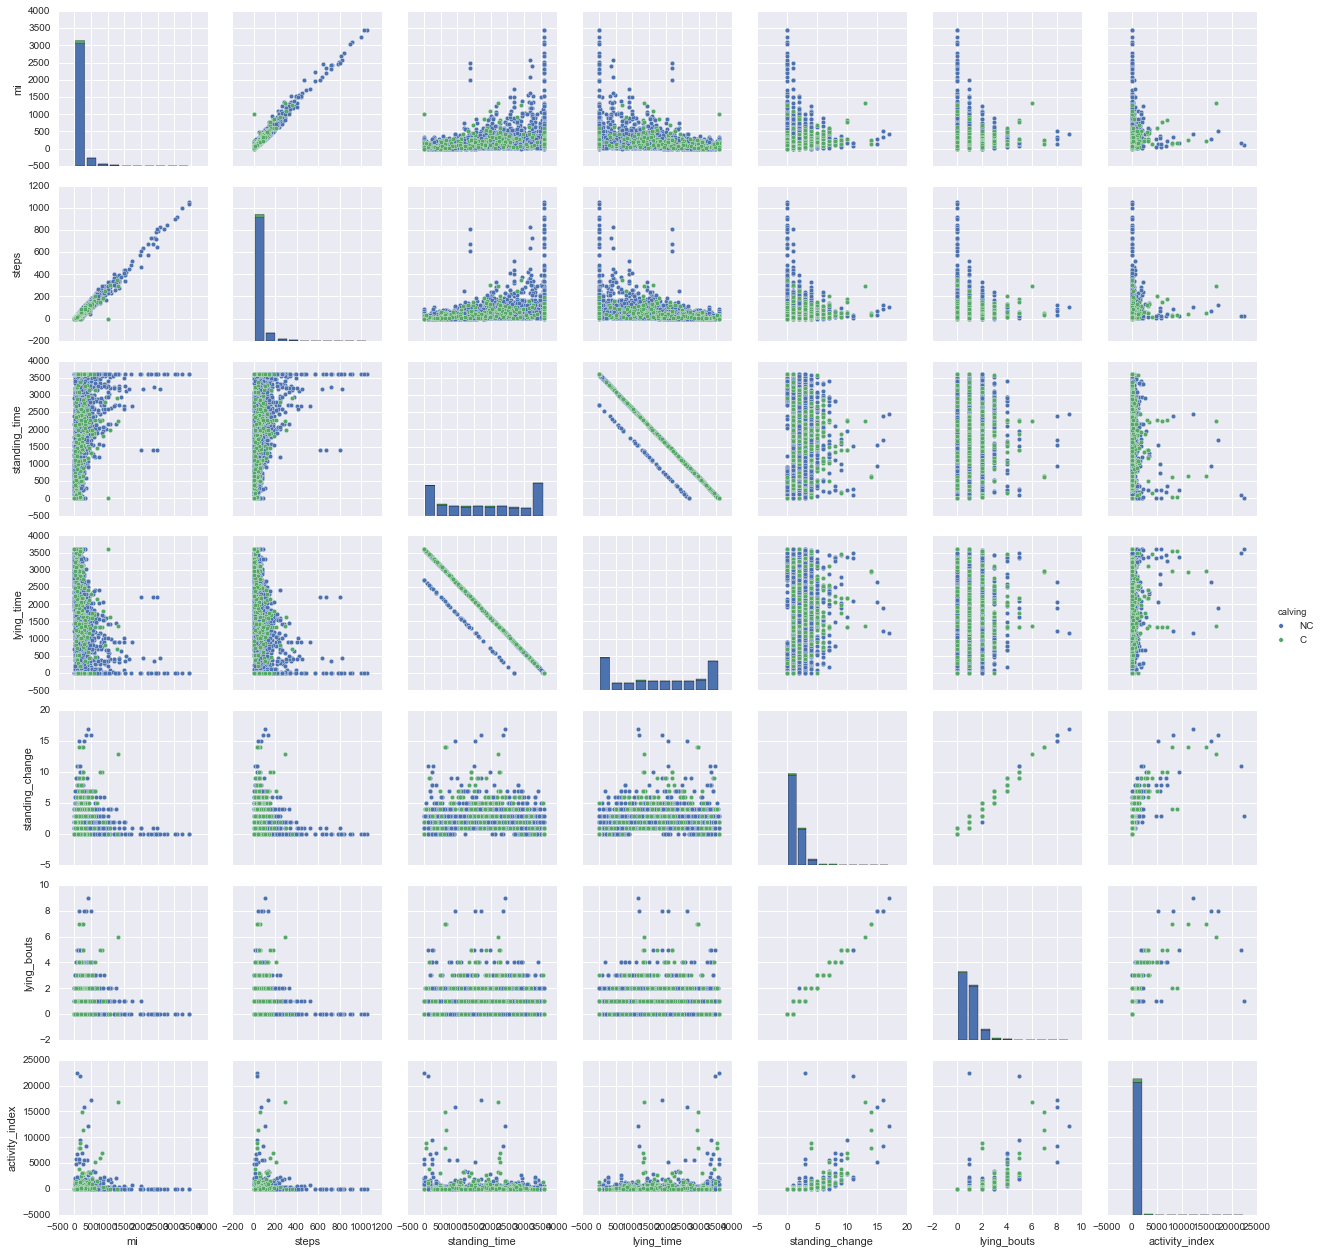

In [12]:
#plotting a scatter plot to visualize the interaction of attributes in the dataframe - are they seperable?
df_plot=df.drop(['subject','start','cow_id'],axis=1)
sns_plot=sns.pairplot(df_plot,hue='calving')
sns_plot.savefig('pairplot_2hr.png')

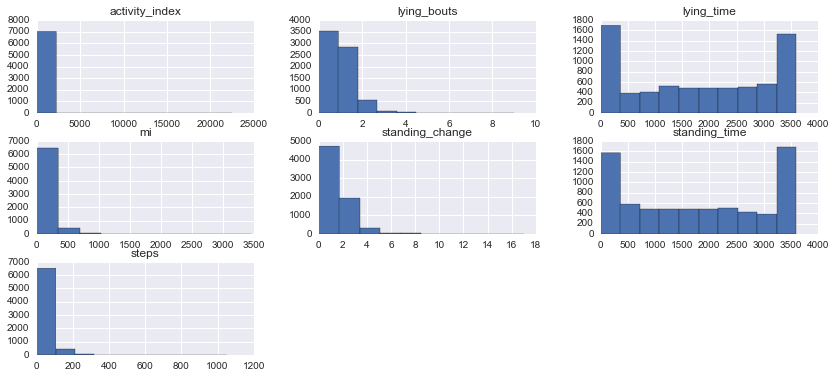

In [13]:
#plot histograms to understand the distribution of attributes
df_plot.hist(figsize=(14,6))
plt.savefig('histogram_2h_all_classes')

calving
C     [[Axes(0.125,0.684722;0.215278x0.215278), Axes...
NC    [[Axes(0.125,0.684722;0.215278x0.215278), Axes...
dtype: object

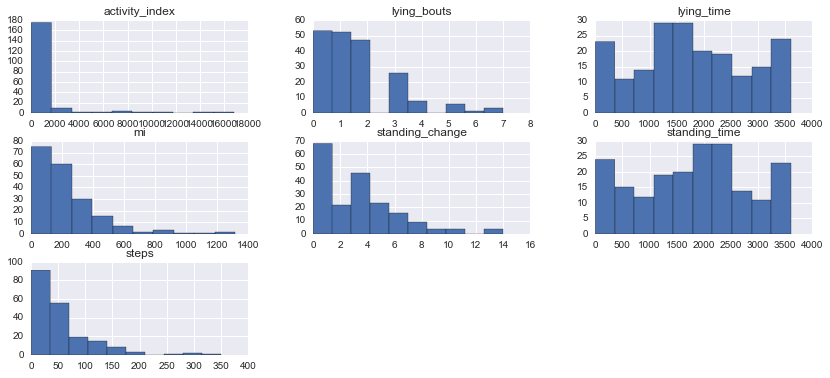

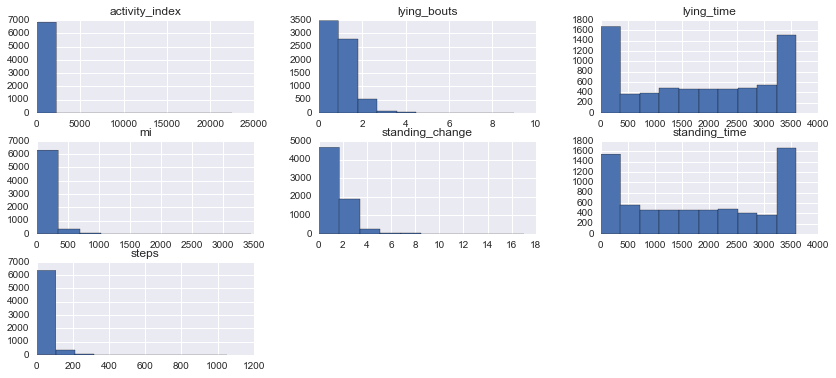

In [14]:
#plot histograms by class to see the distributions within the class
df_plot.groupby('calving').hist(figsize=(14,6))

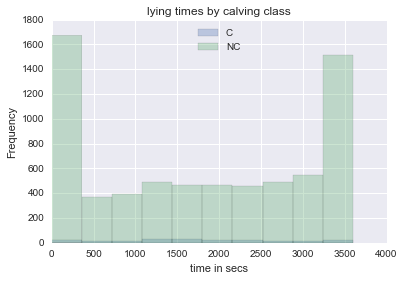

In [15]:
#overlay plot to compare distributions by attributes - data imbalance obscures class - C
df_plot.groupby("calving").lying_time.plot(kind='hist',alpha=0.3,title='lying times by calving class',legend = True)
plt.xlabel('time in secs')
plt.savefig('hist_overlay_lying_times_2h')

Calving Instances: 2.78 pct
Non-Calving Instances: 97.22 pct


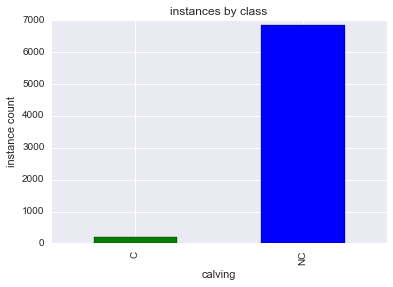

In [16]:
#percentage of instances by type in dataset
calving_inst = df_plot[df_plot['calving']=='C'].count(axis=0)[0]
non_calving_inst=df_plot[df_plot['calving']=='NC'].count(axis=0)[0]
total_inst=calving_inst+non_calving_inst
print "Calving Instances: %.2f pct"%(calving_inst/total_inst*100)
print "Non-Calving Instances: %.2f pct"%(non_calving_inst/total_inst*100)
calving_group=df_plot.groupby('calving')
calving_group_total=calving_group.count()
calving_group_total.mi.plot(kind='bar',title='instances by class',color=['g','b'])
plt.ylabel('instance count')
plt.savefig('instances by class')

### Experiment 1: Splitting the dataframe into a training and test set based on sensor BL
The expriment is used to test a base case scenario where only BL sensors are considered for modelling purposes. 

##### Advantage: maintains the purity of carrying out testing based on a sensor placement that is available on all animals in most farms, including HarperAdams.

##### Disadvantage: reduces the dataset available for modelling from a potential 7056 instances across 3 days to 2448 instances.

In [17]:
#create a data set with just the BL sensors
df['sensor_id']=df.subject.str.slice(start=-2)

In [18]:
#setup a new dataframe that contains only 'BL' sensors
df_BL=df[df['sensor_id']=='BL']

In [19]:
#check that the number of rows is equal to 2448 - 34 cows* 3 days * 24 readings/day 
assert df_BL.shape[0]==2448

In [20]:
#check the attributes
df_BL.head()

,subject,start,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index,calving,cow_id,sensor_id
0,112BL,16/08/2015 00:00,0,0,881,2719,0,0,0,NC,112,BL
1,112BL,16/08/2015 01:00,54,13,1175,2425,2,1,40,NC,112,BL
2,112BL,16/08/2015 02:00,33,9,428,3172,2,1,76,NC,112,BL
3,112BL,16/08/2015 03:00,19,4,341,3259,2,1,42,NC,112,BL
4,112BL,16/08/2015 04:00,7,1,739,2861,1,0,0,NC,112,BL


Calving Instances in df_BL: 2.78 pct
Non-Calving Instances in df_BL: 97.22 pct


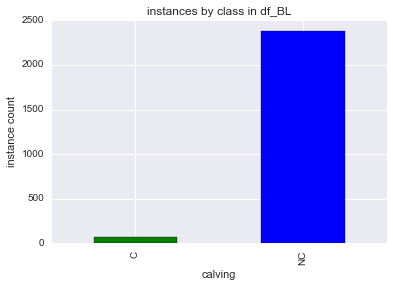

In [21]:
#percentage of instances by type in dataframe df_BL
c_inst_df_BL = df_BL[df_BL['calving']=='C'].count(axis=0)[0]
nc_inst_df_BL=df_BL[df_BL['calving']=='NC'].count(axis=0)[0]
tinst_df_BL=c_inst_df_BL+nc_inst_df_BL
print "Calving Instances in df_BL: %.2f pct"%(c_inst_df_BL/tinst_df_BL*100)
print "Non-Calving Instances in df_BL: %.2f pct"%(nc_inst_df_BL/tinst_df_BL*100)
c_grp_df_bl=df_BL.groupby('calving')
c_grp_tot=c_grp_df_bl.count()
c_grp_tot.mi.plot(kind='bar',title='instances by class in df_BL',color=['g','b'])
plt.ylabel('instance count')
plt.savefig('instances by class in df_BL')

In [22]:
#drop the attributes that are flat and wide - subject, start,cow_id,sensor_id
df_BL.drop(['subject','start','cow_id','sensor_id'],axis=1,inplace=True)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [23]:
df_BL.head()

,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index,calving
0,0,0,881,2719,0,0,0,NC
1,54,13,1175,2425,2,1,40,NC
2,33,9,428,3172,2,1,76,NC
3,19,4,341,3259,2,1,42,NC
4,7,1,739,2861,1,0,0,NC


In [24]:
#split out the validation set from df_BL
array=df_BL.values
X=array[:,0:7]
Y=array[:,7]
validation_size=0.2
seed=7 #fixed to allow comparison across different models
X_train_2,X_validation_2,y_train_2,y_validation_2 = cross_validation.train_test_split(X,Y,test_size=validation_size,random_state=seed)

In [25]:
#use SMOTE on the training set
verbose=True
ratio='auto'
smote=SMOTE(ratio=ratio,kind='regular')
X_train_2_smote,y_train_2_smote=smote.fit_sample(X_train_2,y_train_2)

In [26]:
#check the X_train_2_smote and y_train_2_smote
print "X_train_2_smote:",X_train_2_smote.shape
print "y_train_2_smote:",y_train_2_smote.shape

X_train_2_smote: (3800L, 7L)
y_train_2_smote: (3800L,)


In [27]:
#check for the count of instances of each class
y_2_smote_class_count=Counter(y_train_2_smote)
y_2_train_class_count=Counter(y_train_2)
#Difference between y_train and y_train_smote
class_diff_2=[y_2_smote_class_count[k]-y_2_train_class_count[k] for k,v in zip(y_2_smote_class_count,y_2_train_class_count)]
print "class count difference Calving: ",class_diff_2[0], "instances added"
print "class count difference Non_Calving:",class_diff_2[1],"instances added"

class count difference Calving:  1842 instances added
class count difference Non_Calving: 0 instances added


In [28]:
#scale the attributes in the X_train and X_validation splits, useful for gradient descent optimization
sc=StandardScaler()
sc.fit(X_train_2_smote)
X_train_2_smote_std=sc.transform(X_train_2_smote)
X_validation_2_std=sc.transform(X_validation_2)

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
#test options and evaluation metric
num_folds=10
num_instances=len(X_train_2_smote_std)
seed=7
scoring='accuracy'

In [30]:
#spot check the algorithms
#Algorithms - logisticregression,lineardiscriminantanalysis,knn,classification and regression trees(CART),Gaussian Naive Bayes(NB),Support Vector Machines(SVM), Perceptron
models=[]
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('PPN',Perceptron()))
#evaluate each model in turn
results=[]
names=[]
for name,model in models:
    kfold=cross_validation.KFold(n=num_instances,n_folds=num_folds,random_state=seed)
    cv_results=cross_validation.cross_val_score(model,X_train_2_smote_std,y_train_2_smote,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg='%s: %f (%f)'%(name,cv_results.mean(),cv_results.std())
    print msg

LR: 0.746842 (0.057436)
LDA: 0.742632 (0.079409)
KNN: 0.915263 (0.031880)
CART: 0.941316 (0.018573)
NB: 0.687368 (0.221359)
SVM: 0.766579 (0.073619)
PPN: 0.639211 (0.186729)


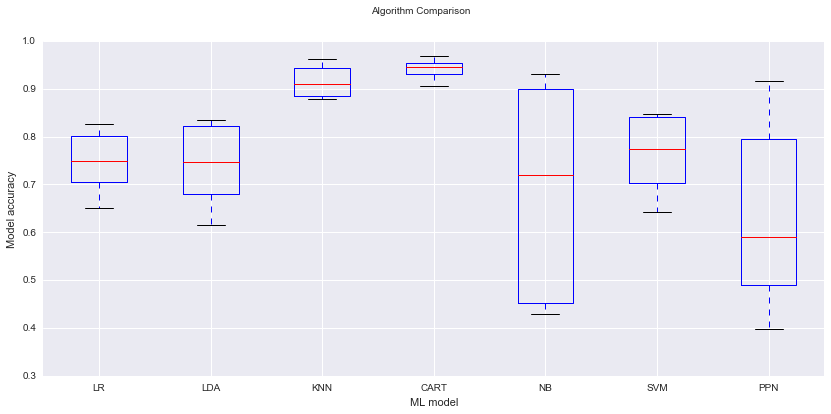

In [31]:
#plots comparing the algorithms
fig=plt.figure(figsize=(14,6))
fig.suptitle('Algorithm Comparison')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xlabel('ML model')
plt.ylabel('Model accuracy')
plt.show()

In [32]:
print "y_train_2_smote:",Counter(y_train_2_smote)
print "y_validation_2:",Counter(y_validation_2)

y_train_2_smote: Counter({'C': 1900, 'NC': 1900})
y_validation_2: Counter({'NC': 480, 'C': 10})


In [66]:
#make predicitions on validation dataset - using knn
knn=KNeighborsClassifier()
knn.fit(X_train_2_smote_std,y_train_2_smote)
predictions=knn.predict(X_validation_2_std)
print "accuracy score:\n",accuracy_score(y_validation_2,predictions)
print  "confusion matrix:\n",confusion_matrix(y_validation_2,predictions)
print "classification report\n:",classification_report(y_validation_2,predictions)

accuracy score:
0.883673469388
confusion matrix:
[[  2   8]
 [ 49 431]]
classification report
:              precision    recall  f1-score   support

          C       0.04      0.20      0.07        10
         NC       0.98      0.90      0.94       480

avg / total       0.96      0.88      0.92       490



In [67]:
#make predictions on validation dataset - using CART
cart=DecisionTreeClassifier()
cart.fit(X_train_2_smote_std,y_train_2_smote)
predictions=cart.predict(X_validation_2_std)
print "accuracy score:\n",accuracy_score(y_validation_2,predictions)
print "confusion matrix:\n",confusion_matrix(y_validation_2,predictions)
print "classification report\n:",classification_report(y_validation_2,predictions)

accuracy score:
0.910204081633
confusion matrix:
[[  1   9]
 [ 35 445]]
classification report
:              precision    recall  f1-score   support

          C       0.03      0.10      0.04        10
         NC       0.98      0.93      0.95       480

avg / total       0.96      0.91      0.93       490



In [35]:
#make predictions on validation dataset - using PPN
ppn=Perceptron()
ppn.fit(X_train_2_smote_std,y_train_2_smote)
predictions=ppn.predict(X_validation_2_std)
print "accuracy score:\n",accuracy_score(y_validation_2,predictions)
print "confusion matrix:\n",confusion_matrix(y_validation_2,predictions)
print "classification report\n:",classification_report(y_validation_2,predictions)

accuracy score:
0.622448979592
confusion matrix:
[[  4   6]
 [179 301]]
classification report
:              precision    recall  f1-score   support

          C       0.02      0.40      0.04        10
         NC       0.98      0.63      0.76       480

avg / total       0.96      0.62      0.75       490



In [36]:
#make predictions on validation dataset - using SVM
svm=SVC()
svm.fit(X_train_2_smote_std,y_train_2_smote)
predictions=svm.predict(X_validation_2_std)
print "accuracy score:\n",accuracy_score(y_validation_2,predictions)
print "confusion matrix:\n",confusion_matrix(y_validation_2,predictions)
print "classification report\n:",classification_report(y_validation_2,predictions)

accuracy score:
0.863265306122
confusion matrix:
[[  2   8]
 [ 59 421]]
classification report
:              precision    recall  f1-score   support

          C       0.03      0.20      0.06        10
         NC       0.98      0.88      0.93       480

avg / total       0.96      0.86      0.91       490



### Experiment 2: Splitting the dataframe into a training and test set based on the subject attribute
The expriment is used to split up the training and test set so as to preserve the use of all 3 sensors in both sets i.e. sensors BL, BR and FL appear in both the training and test sets respectively. The data is split such that cows in the training set do not appear in the test set and as such prevents confounding of the model accuracy.
##### Advantage: allows the use of the entire dataset for training and testing.



##### Disadvantage:  does not allow the use of cross validation as the training set contains all 3 sensors from each cow and an attempt at cross-validation will result in overfitting

In [37]:
#split data into training and test-sets
train = 0.67
test = 0.33
#find unique cow_ids
cows_id=df.cow_id.unique()
#select a training sample of unique cow_ids using uniform random sampling without replacement
train=np.random.choice(cows_id,round(train*len(cows_id),0),replace=False)
#filter the df to include only elements in the train set
training_set = df[df.cow_id.isin(train)]
testing_set=df[~df.cow_id.isin(train)]

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [213]:
#function to split the dataframe into a training and test set
def tt_split(train_split):
    train=train_split
    test=1-train
    #find unique cow ids
    cows_id=df.cow_id.unique()
    #select a training sample of unique cow_ids using uniform random sampling without replacement
    train=np.random.choice(cows_id,round(train*len(cows_id),0),replace=False)
    #filter the df to include only elements in the train set
    training_set = df[df.cow_id.isin(train)]
    testing_set=df[~df.cow_id.isin(train)]
    #drop the training set columns that do not provide any pattern - falt and wide columns
    training_set.drop(['subject','start','cow_id'],axis=1,inplace=True)
    #drop the testing set columns that do not provide any pattern - falt and wide columns
    testing_set.drop(['subject','start','cow_id'],axis=1,inplace=True)
    #split the training-set to X_train,y_train
    X_train = training_set.ix[:,'mi':'activity_index']
    y_train=training_set.ix[:,'calving']
    #split the testing-set to X_test,y_test
    X_test = testing_set.ix[:,'mi':'activity_index']
    y_test=testing_set.ix[:,'calving']
    return X_train,y_train,X_test,y_test

In [138]:
training_set.describe()

,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index
count,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000
mean,143.400042,38.153409,1738.220749,1849.279251,1.269571,0.633207,120.535354
std,243.407194,71.317483,1338.875668,1337.322076,1.476233,0.809031,789.231887
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,3.000000,386.750000,476.250000,0.000000,0.000000,0.000000
50%,84.000000,20.000000,1626.000000,1959.000000,1.000000,0.000000,0.000000
75%,172.000000,46.000000,3097.500000,3198.000000,2.000000,1.000000,53.000000
max,3457.000000,1054.000000,3600.000000,3600.000000,17.000000,9.000000,22500.000000


In [139]:
testing_set.describe()

,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,154.095052,41.338976,1906.087674,1681.412326,1.279514,0.636719,85.019965
std,175.786468,48.251198,1306.178421,1303.022408,1.321191,0.743457,457.996813
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,6.000000,616.750000,323.250000,0.000000,0.000000,0.000000
50%,105.000000,27.000000,1938.500000,1640.500000,1.000000,1.000000,0.000000
75%,204.250000,58.000000,3267.500000,2961.250000,2.000000,1.000000,62.000000
max,1537.000000,397.000000,3600.000000,3600.000000,13.000000,6.000000,16824.000000


In [41]:
#drop the training set columns that do not provide any pattern - falt and wide columns
training_set.drop(['subject','start','cow_id'],axis=1,inplace=True)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [42]:
#check the training-set
training_set.shape

(4752, 9)

Calving Instances: 2.78 pct
Non-Calving Instances: 97.22 pct


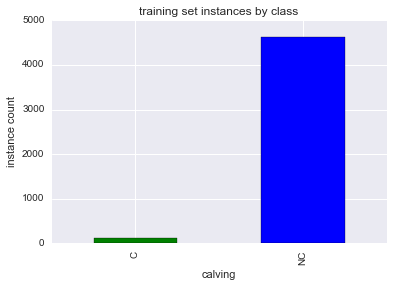

In [43]:
#percentage of instances by type in training set
t_calving_inst = training_set[training_set['calving']=='C'].count(axis=0)[0]
t_non_calving_inst=training_set[training_set['calving']=='NC'].count(axis=0)[0]
t_total_inst=t_calving_inst+t_non_calving_inst
print "Calving Instances: %.2f pct"%(t_calving_inst/t_total_inst*100)
print "Non-Calving Instances: %.2f pct"%(t_non_calving_inst/t_total_inst*100)
t_calving_group=training_set.groupby('calving')
t_calving_group_total=t_calving_group.count()
t_calving_group_total.mi.plot(kind='bar',title='training set instances by class',color=['g','b'])
plt.ylabel('instance count')
plt.savefig('instances by class in training set')

In [44]:
#drop the testing set columns that do not provide any pattern - falt and wide columns
testing_set.drop(['subject','start','cow_id'],axis=1,inplace=True)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [45]:
#check the testing-set
testing_set.shape

(2304, 9)

In [46]:
#split the training-set to X_train,y_train
X_train = training_set.ix[:,'mi':'activity_index']
y_train=training_set.ix[:,'calving']

In [47]:
#check X_train
X_train.head()

,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index
0,0,0,881,2719,0,0,0
1,54,13,1175,2425,2,1,40
2,33,9,428,3172,2,1,76
3,19,4,341,3259,2,1,42
4,7,1,739,2861,1,0,0


In [48]:
#check y_train
y_train.head()

0    NC
1    NC
2    NC
3    NC
4    NC
Name: calving, dtype: object

In [49]:
#split the testing-set to X_test,y_test
X_test = testing_set.ix[:,'mi':'activity_index']
y_test=testing_set.ix[:,'calving']

In [50]:
#check X_test
X_test.head()

,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index
432,0,0,0,3600,0,0,0
433,33,4,615,2985,2,1,23
434,36,5,442,3158,4,2,163
435,32,9,638,2962,1,0,0
436,19,4,611,2989,1,1,24


In [51]:
#check y_test
y_test.head()

432    NC
433    NC
434    NC
435    NC
436    NC
Name: calving, dtype: object

X_test dimension:  (2304, 7)
y_test dimension:  (2304L,)
Calving Instances: 0.03 %


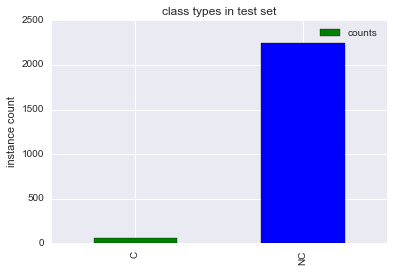

In [52]:
#check size of X_test and y_test
print "X_test dimension: ",X_test.shape
print "y_test dimension: ", y_test.shape
print "Calving Instances: %.2f %%"%(Counter(y_test)['C']/(Counter(y_test)['C']+Counter(y_test)['NC']))
y_test_df=pd.DataFrame.from_dict(Counter(y_test),orient='index')
y_test_df.rename(columns={'index':'class',0:'counts'},inplace=True)
y_test_df.plot(kind='bar',color=['g','b'],title='class types in test set')
plt.ylabel('instance count')
plt.savefig('class instances in test set')

In [89]:
#reduce the training dataset class imbalance by oversampling the minority class,C, using SMOTE
def class_balance(X_train,y_train):
    verbose=True
    ratio='auto'
    smote=SMOTE(ratio=ratio,kind='regular')
    X_train_smote,y_train_smote=smote.fit_sample(X_train,y_train)
    return X_train_smote,y_train_smote

In [90]:
class_balance(X_train,y_train)

(array([[  0.00000000e+00,   0.00000000e+00,   8.81000000e+02, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  5.40000000e+01,   1.30000000e+01,   1.17500000e+03, ...,
           2.00000000e+00,   1.00000000e+00,   4.00000000e+01],
        [  3.30000000e+01,   9.00000000e+00,   4.28000000e+02, ...,
           2.00000000e+00,   1.00000000e+00,   7.60000000e+01],
        ..., 
        [  2.23302943e+02,   5.01748855e+01,   1.58514506e+03, ...,
           8.86945717e+00,   4.00000000e+00,   1.83690464e+03],
        [  1.03052148e+02,   2.02630371e+01,   2.15520791e+03, ...,
           1.82204939e+00,   4.11024693e-01,   3.04158273e+01],
        [  9.19704977e+01,   1.83940411e+01,   5.74241128e+02, ...,
           3.28465019e-01,   0.00000000e+00,   0.00000000e+00]]),
 array(['NC', 'NC', 'NC', ..., 'C', 'C', 'C'], dtype=object))

In [54]:
X_train_smote.shape

(9240L, 7L)

In [55]:
y_train_smote.shape

(9240L,)

In [56]:
#check for the count of instances of each class
y_smote_class_count=Counter(y_train_smote)
y_train_class_count=Counter(y_train)
#Difference between y_train and y_train_smote
class_diff=[y_smote_class_count[k]-y_train_class_count[k] for k,v in zip(y_smote_class_count,y_train_class_count)]
print "class count difference Calving: ",class_diff[0], "instances added"
print "class count difference Non_Calving:",class_diff[1],"instances added"

class count difference Calving:  4488 instances added
class count difference Non_Calving: 0 instances added


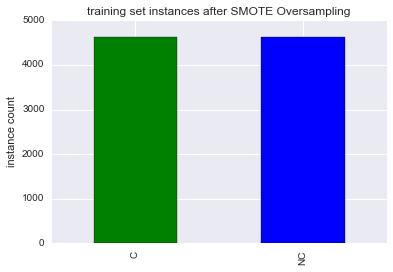

In [57]:
y_smote_class_df=pd.DataFrame.from_dict(y_smote_class_count,orient='index')
y_smote_class_df.rename(columns={'index':'class',0:'counts'},inplace=True)
y_smote_class_df.plot(kind='bar',color=['g','b'],title='training set instances after SMOTE Oversampling',legend=False)
plt.ylabel('instance count')
plt.savefig('instances in training set after SMOTE Oversampling')

In [91]:
#scale the attributes in the X_train and X_test splits, useful for gradient descent optimization
def zscore_scaling(X_train_smote,X_test):
    sc=StandardScaler()
    sc.fit(X_train_smote)
    X_train_smote_std=sc.transform(X_train_smote)
    X_test_std=sc.transform(X_test)
    return X_train_smote_std,X_test_std


In [214]:
#spot check the algorithms
#Algorithms - logisticregression,lineardiscriminantanalysis,knn,classification and regression trees(CART),Gaussian Naive Bayes(NB),Support Vector Machines(SVM), Perceptron
models=[]
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('PPN',Perceptron()))
#evaluate each model in turn
kfolds=10
for name,model in models:
    results=[]
    for kfold in range(kfolds):
        tt_split(0.67)
        class_balance(X_train,y_train)
        zscore_scaling(X_train_smote,X_test)
        model.fit(X_train_smote_std,y_train_smote)
        y_pred=model.predict(X_test_std)
        results.append(accuracy_score(y_test,y_pred))
    res=np.array(results)
    print '%s: %f (%f)'%(name,res.mean(),res.std())


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


LR: 0.798611 (0.000000)
LDA: 0.813368 (0.000000)
KNN: 0.857205 (0.000000)
CART: 0.899132 (0.001290)
NB: 0.908420 (0.000000)
SVM: 0.857205 (0.000000)
PPN: 0.657118 (0.000000)


In [64]:
#grid search for parameters
fieldnames=['n_iter','eta0','error_rate','acc_score']
gridFile=open('parameters.csv','wb')
gridFileWriter=csv.writer(gridFile)
gridFileWriter.writerow(fieldnames)
def ppn_model(n_iter_param,eta0_param):
    #train using a perceptron model
    ppn=Perceptron(n_iter=n_iter_param,eta0=eta0_param,random_state=0)
    ppn.fit(X_train_smote_std,y_train_smote)
    y_pred=ppn.predict(X_test_std)
    error_rate=(y_test!=y_pred).sum()/y_test.shape[0]
    acc_score=accuracy_score(y_test,y_pred)
    print '\t misclassified samples: %.2f %%'%(error_rate*100)
    print '\t accuracy: %.2f %% \n'%(acc_score*100)
    gridFileWriter.writerow([n_iter_param,eta0_param,error_rate,acc_score])
    
for n_iter_param in range(10,510,10):
    print "n_iter_param: ",n_iter_param
    for eta0_param in arange(0.1,1.1,0.1):
        print "\t eta0_param: ",eta0_param
        ppn_model(n_iter_param,eta0_param)
gridFile.close()

n_iter_param:  10
	 eta0_param:  0.1
	 misclassified samples: 42.58 %
	 accuracy: 57.42 % 

	 eta0_param:  0.2
	 misclassified samples: 42.58 %
	 accuracy: 57.42 % 

	 eta0_param:  0.3
	 misclassified samples: 42.58 %
	 accuracy: 57.42 % 

	 eta0_param:  0.4
	 misclassified samples: 42.58 %
	 accuracy: 57.42 % 

	 eta0_param:  0.5
	 misclassified samples: 42.58 %
	 accuracy: 57.42 % 

	 eta0_param:  0.6
	 misclassified samples: 42.58 %
	 accuracy: 57.42 % 

	 eta0_param:  0.7
	 misclassified samples: 42.58 %
	 accuracy: 57.42 % 

	 eta0_param:  0.8
	 misclassified samples: 42.58 %
	 accuracy: 57.42 % 

	 eta0_param:  0.9
	 misclassified samples: 42.58 %
	 accuracy: 57.42 % 

	 eta0_param:  1.0
	 misclassified samples: 42.58 %
	 accuracy: 57.42 % 

n_iter_param:  20
	 eta0_param:  0.1
	 misclassified samples: 38.63 %
	 accuracy: 61.37 % 

	 eta0_param:  0.2
	 misclassified samples: 38.63 %
	 accuracy: 61.37 % 

	 eta0_param:  0.3
	 misclassified samples: 38.63 %
	 accuracy: 61.37 % 

	 